# Notebook for Determining Global Variables

__About:__  
The most challenging and most influential step in the data processing is the center finding. Use this notebook to optimize the global variables that are used in both the center finding algorithm including `CENTER_GUESS`, `RADIUS_GUESS`, `DISK_RADIUS`, and `THRESHOLD` and the masking algorithm including `MASK_CENTER`, `MASK_RADIUS`, and `ADDED_MASK`  
  
 __!! Each time you change a global variable, restart your kernel and rerun the following code blocks until you're happy with the result !!__

## Global Variable Usage
The package `gued.py` relies on a few global variables which should be optimized for each experiment. The global variables are stored in `gued_globals.py` and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)). 

In [1]:
%%writefile gued_globals.py
### Global Variables for IR CF3I data set

# Variable for reading files
SEPARATORS = ['-', '_']

# Variables for Center Finding Algorithm
CENTER_GUESS = (465, 475)
RADIUS_GUESS = 35
DISK_RADIUS = 3
THRESHOLD = 0

# Variable for Generating Background
CORNER_RADIUS = 20
CHECK_NUMBER = 50

# Variables for Masking
MASK_CENTER = [545, 495]
MASK_RADIUS = 45
ADDED_MASK = []
# Rectangular Mask Details. If not needed just ignore
REC_LENGTH = 535 # start position of rectangle within the image
REC_EXTENT = (540, 30) # (length, width) # Use () not []

# Used throughout code as the threshold for cutting out date. This is the default value but other values can be set for the functions using
# std_factor = 4
STD_FACTOR = 2

# Specifies the maximum number of workers to be used when running concurrent.futures
MAX_PROCESSORS = 6

# Adjust figure size 
FIGSIZE = (12,4)

# Path for Theory Package

PATH_DCS = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\Coding Lab Notebook\\gued_package\\GUED_Analysis\\packages\\dcs_repositiory\\3.7MeV\\'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/ding Lab Notebook\\gued_package\\GUED_Analysis\\packages\\dcs_repositiory\\3.7MeV\\'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/


Overwriting gued_globals.py


## Import Packages

In [2]:
# Standard Packages
import numpy as np
import glob
import matplotlib.pyplot as plt
import random


# new code 
import gued

#interactive plotting 
%matplotlib widget

## Reading in Data and Visualizing

In [3]:
help(gued.get_image_details_keV)

Help on function get_image_details_keV in module gued:

get_image_details_keV(file_names, sort=False, multistage=False, filter_data=False, plot=False)
    Reads all images from input file_names and returns the data as a 3d array along with stage positions, order, and counts per image.
    
    ARGUMENTS:
    
    file_names (list):
        list of file names to be read in
    
    OPTIONAL ARGUMENTS:
    
    sort (boolean): 
        default is set to True. This arguments sorts the data based on when it was saved (i.e. file number)
    multistage (boolean):
        default is set to False. Use this when file names contain information from multiple stages.
    plot (boolean): 
        default is set to False. When True, a plot of the data, log(data), and histogram of counts is shown
    filter_data (boolean): 
        default is set to False. When True, code prompts you for a minimum and maximum value then
        returns only the information from files within this range
    
    RETURN

Path to images  C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\UV_IR_exp\07222024\Time_Scans\Scan 9\\Image_*.tiff
Number of files loaded:  300
Load diffraction signal
sorting based on UV stage position


c:\Users\laure\OneDrive - University of Nebraska-Lincoln\Desktop\gued\gued.py:358: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=FIGSIZE)


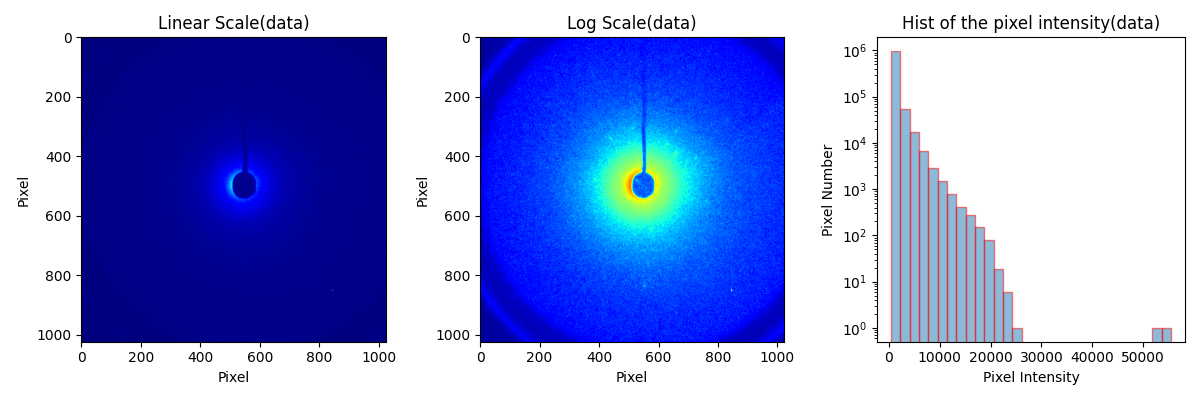

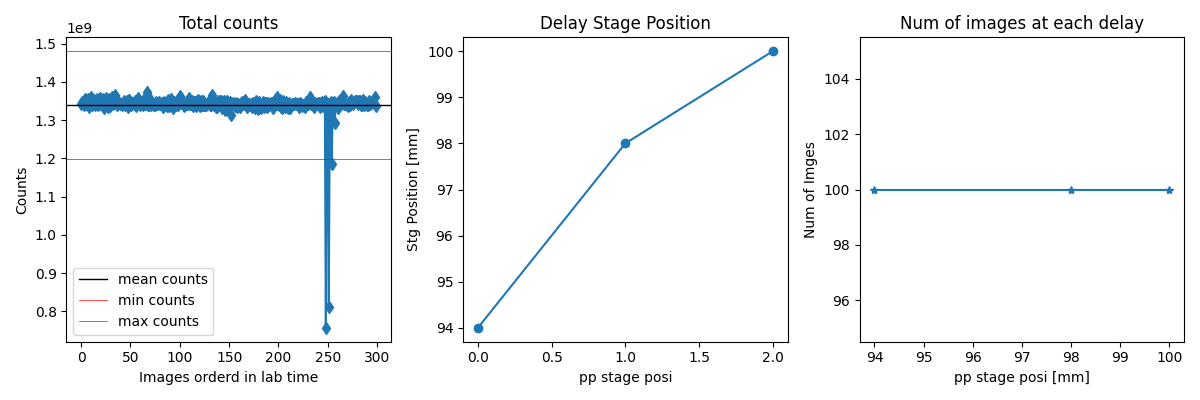

Image number read:  300
Stage positions:  3
100


In [36]:
# Using glob and * place holders to read in all file names from the specified path
data_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\UV_IR_exp\\07222024\\Time_Scans\\Scan 9\\'
run_path = "\\Image_*.tiff"

#bkg_path = '\\work\\centurion\\shared\\UED_data\\FY18_o-nitrophenol\\20180823\\Background\\*\\*\\ANDOR1_*.tif'

full_path = data_path + run_path
print("Path to images ", full_path)
#print("Path to background images ", bkg_path)

files = glob.glob(full_path)
#bkg_files = glob.glob(bkg_path)
print("Number of files loaded: ", len(files))
#print("Number of background files loaded: ", len(bkg_files))


print('Load diffraction signal');
data_array, stage_positions, file_order, counts, _ = gued.get_image_details_keV(files[:], sort=True, multistage=True, filter_data=False, plot=True)

counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))
print(len(np.unique(file_order)))

## Create Test Set of Images and process

Need to do these steps so that variables can be used in the fast analysis notebook

In [37]:
file_numbers = list(range(len(data_array)))
rand_idx = random.sample(file_numbers, 50) 
print(np.array(rand_idx))
data_array = data_array[rand_idx]
print("Removing background")
data_array = gued.remove_background_pool(data_array)
print("Removing xrays")
data_array = gued.remove_xrays_pool(data_array, plot=False)

[223 284 182 245 250   1  47 299  19 161  17 154 192  67 107 207 259 176
 276 117 243 159 269 126 103 260 220 295  71  24  74 213 236 101 148 105
 178 226 224 146  72 130 155  40 169 233 271  83  89 293]
Removing background
Removing xrays
Removing hot pixels from all data


## Find Areas to Mask

In [38]:
help(gued.apply_mask) # for one image, used this function

Help on function apply_mask in module gued:

apply_mask(data_array, fill_value=nan, add_rectangular=False, plot=False, print_vals=False)
    Applies a mask to individual images in the data array.
    
    ARGUMENTS:
    
    data_array (array):
        2D or 3D array of an image or images.
    
    OPTIONAL ARUGMENTS:
    
    fill_value (int, float, or nan):
        Default set to np.nan. Value used to fill the area of the mask.
    add_rectangular (boolean)
        The default is True. Adds an additional mask with rectangular shape. 
    plot (boolean):
        Default set to False. When true, plots a figure with the original data, the masked data, and a contour map of the data
    print_vals (boolean):
        Default set to False. When true, prints the values at each contour line. Useful for setting global variables
    
    GLOBAL VARIABLES:
    
    MASK_CENTER : 1D array, tuple, or list that contains only two values
        Center for generating mask cover unscattered electron b

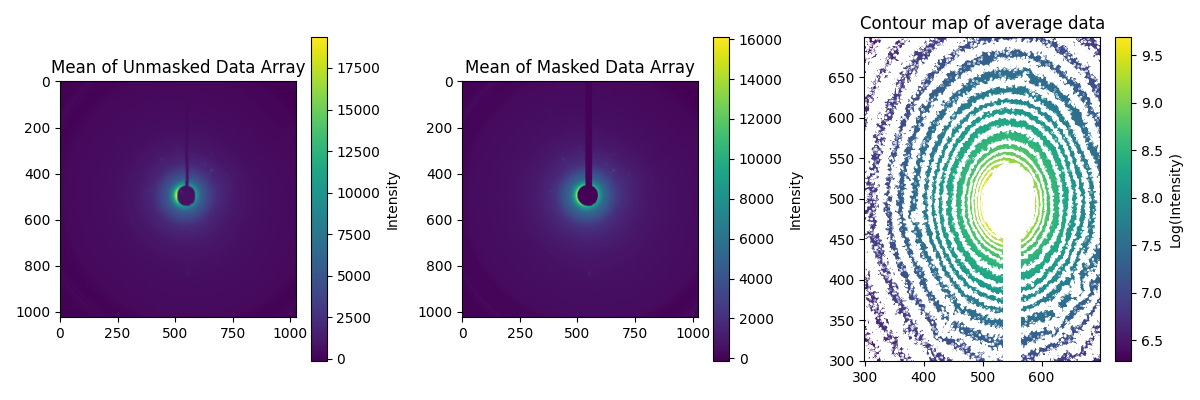

In [39]:
data_array = gued.apply_mask(data_array, fill_value=0.0, add_rectangular=True, plot=True)

## Finding Diffraction Center

In [40]:
help(gued.finding_center_alg) # for one image use this function

Help on function finding_center_alg in module gued:

finding_center_alg(image, plot=False, title='Reference Image')
    Algorithm for finding the center of diffraction pattern
    
    ARGUMENTS:
    
    data_array : 2D array
        Diffraction pattern.
    
    OPTIONAL ARGUMENTS:
    
    thresh_input (float):
        Default set to 0. When zero, the threshold value is calculated using threshold_otsu from scikit-images. Often doesn't work
    plot : boolean, optional
        Show figure of the result of center finding. The default is False.
    title : str, optional
        Title of the figure. The default is 'Reference image'.
    
    
    GLOBAL VARIABLES:
    
    DISK_RADIUS : int, optional
        Generates a flat, disk-shaped footprint. The default is 3.
    CENTER_GUESS : tuple contains 2 values, optional
        Guessing center position to generate temporary mask. The default is (532, 520).
    RADIUS_GUESS : int, optional
        Guessing radius of the temporary mask. The

### Find Average Center

Adjust the `THRESHOLD` value then update the `gued_globals.py` file and restart code

In [41]:
# First, check the threshold value being calculated by the code, a good value is usually close to 100
from skimage.filters import threshold_otsu
for data in data_array:
    print(threshold_otsu(data))

2640.1480339183577
2586.5791034013446
2449.797777314252
2609.9578252980405
2635.4827705685434
2601.6053432367635
2597.1433410823593
2593.2402019141223
2647.2525618247428
2565.2667640095806
2547.0151870735313
2609.8664366650482
2599.307961609091
2690.335827208044
2596.562519724943
2663.830812343537
2650.1424835168427
2430.5089384646444
2670.6584434530077
2633.4949137656176
2647.5619696763515
2532.790348651333
2579.402355883563
2599.6695735665417
2670.191544756738
2546.3637842820394
2635.18018741412
2659.718334817056
2591.977808241041
2608.62784767455
2603.4222217814563
2635.7367831339425
2585.1595992476696
2595.7955809466016
2672.07119104077
2602.0143856704017
2667.3907374880637
2628.801371209361
2640.9849753910457
2551.0894694251588
2619.924433102771
2632.7982620250077
2596.7609824360784
2418.6267086514804
2456.8924003581915
2647.461979782556
2628.565328881356
2558.7864472039655
2593.005967449787
2643.5077909593037


In the left most graph below, you want the yellow to look circular at the smallest radius possible so adjust `THRESHOLD` value to minimize radius values and minimize range of found center values

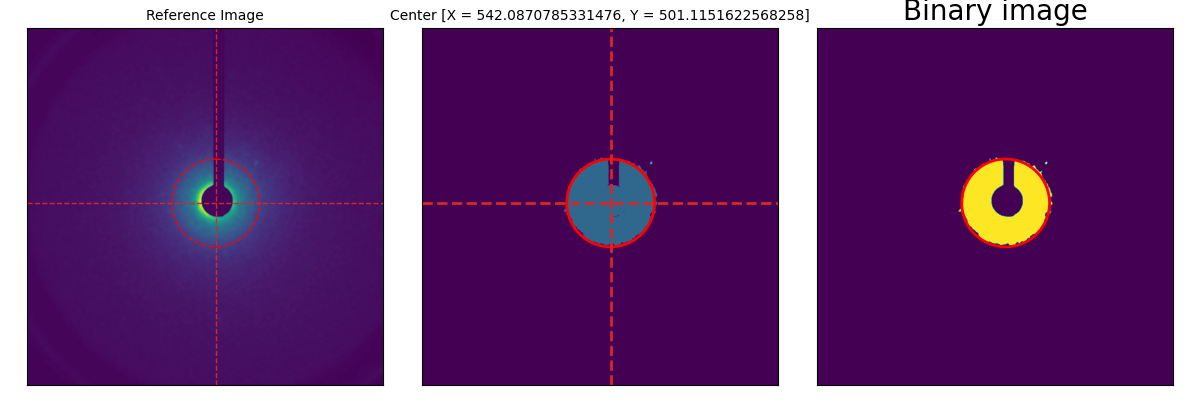

542.0870785331476 501.1151622568258


In [42]:
center_x, center_y, _, _ = gued.finding_center_alg(data_array[0], plot=True)
print(center_x, center_y)

### Find all centers 

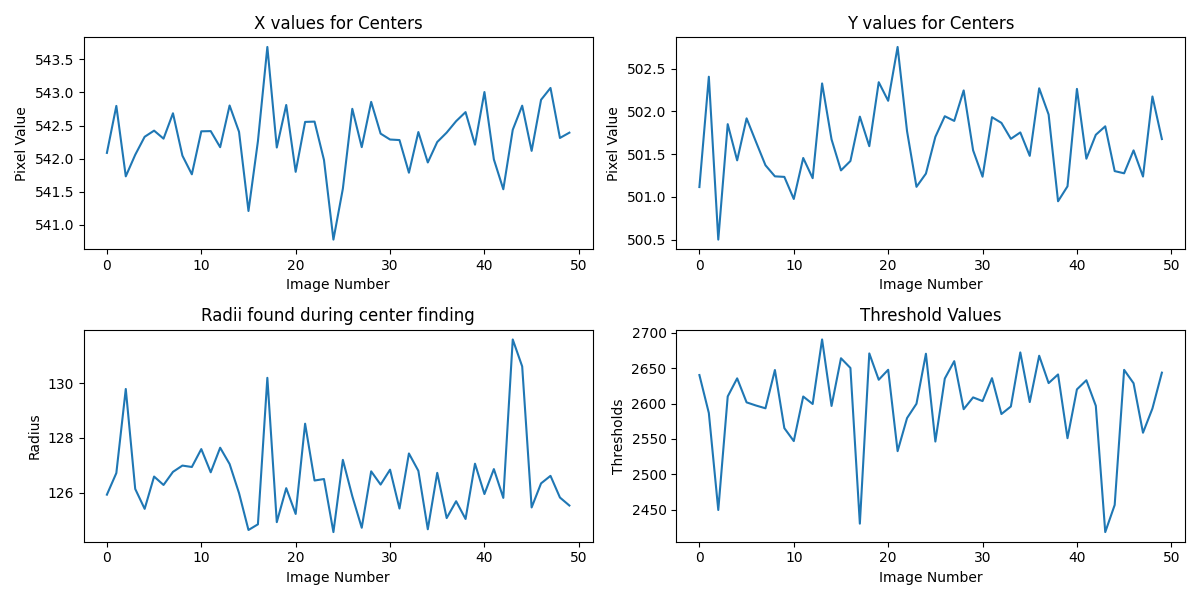

In [43]:
center_x, center_y = gued.find_center_pool(data_array, plot=True)

Now you can run the `Fast_Analysis.ipynb` notebook with the optimized global variables. 